# MAE6292 - Camera Calibration

Camera Calibration and Object Rendering

## Import Modules



In [1]:
import numpy as np
import matplotlib.pyplot as plt

import cv2

## Jupyter Notebook / VS Code

**Note**: skip this cell, if you are running this remotely on Google Colab.

It turns out that `cv2.imshow()` does not work in Jupter Notebook as well. You may use the follwing function `cv2_imshow` instead. 

In [2]:
def cv2_imshow(image):
# developed by Kanishke Gamagedara, udpated by MAE6292
    plt.figure(dpi=200)
    mode = len(np.shape(image))
    if mode==3:
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    elif mode==2:
        plt.imshow(image, cmap='gray')
    else:
        print('Unsuported image size')
        raise
    plt.xticks([]), plt.yticks([]) 
    plt.axis('off')

## Calibration with OpenCV

An image of chessboard is loaded.



[[ 67  67  67 ... 102 103 108]
 [ 67  67  67 ... 102 103 108]
 [ 66  66  67 ... 102 103 108]
 ...
 [ 22  22  23 ... 148 149 151]
 [ 23  23  23 ... 149 150 152]
 [ 24  23  23 ... 149 150 153]]


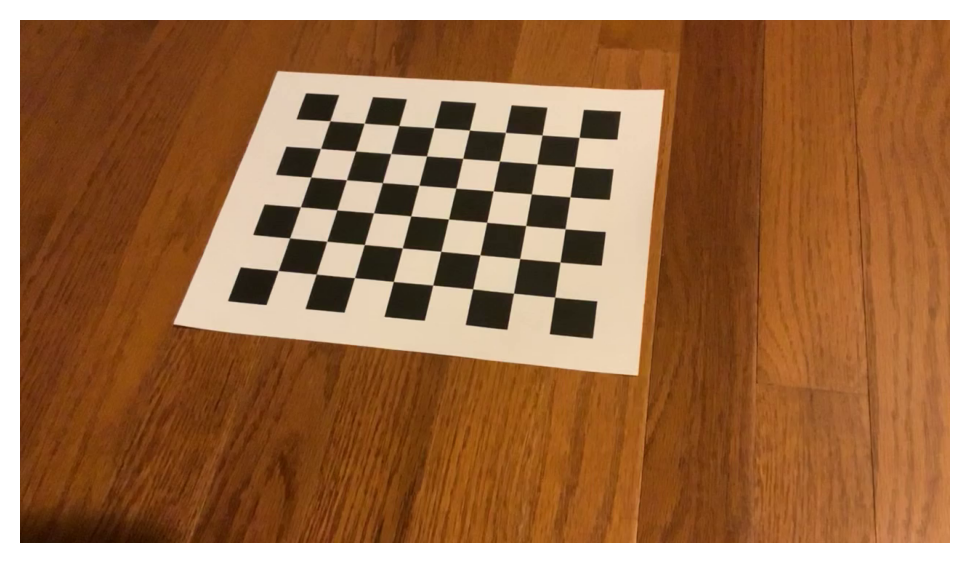

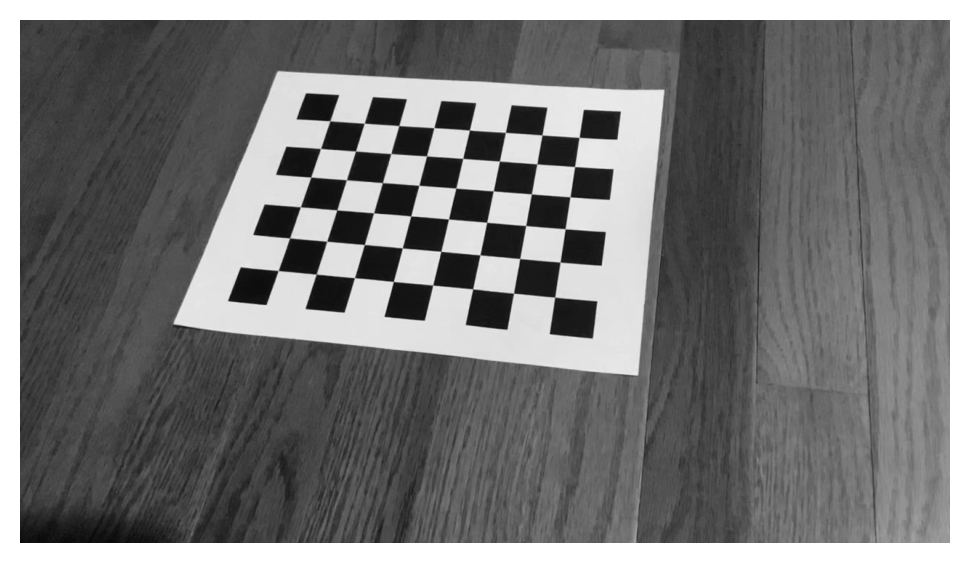

In [3]:
img = cv2.imread('data/frame0.png')
cv2_imshow(img)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
cv2_imshow(img_gray)

print(img_gray)

The checker size corresponds to the number of **INNER CORNERS**.
The pixel coordinates of those corners can be detected by [cv2.findChessboardCorners()](https://docs.opencv.org/master/d9/d0c/group__calib3d.html#ga93efa9b0aa890de240ca32b11253dd4a), and they are visualized by [cv2.drawChessboardCorners](https://docs.opencv.org/master/d9/d0c/group__calib3d.html#ga6a10b0bb120c4907e5eabbcd22319022)

True
(48, 1, 2)
[[[426.95624 139.98434]]

 [[473.7428  143.29941]]

 [[521.43756 146.62434]]

 [[569.7547  149.46184]]

 [[618.6995  152.68712]]

 [[668.3313  155.81758]]

 [[718.7596  159.5406 ]]

 [[769.7     162.77284]]

 [[413.8132  178.1318 ]]

 [[462.03366 181.54657]]

 [[510.4154  185.02301]]

 [[559.7131  188.42636]]

 [[609.60205 191.55064]]

 [[659.9059  195.31702]]

 [[711.5849  199.28647]]

 [[763.4956  202.95685]]

 [[400.56122 217.33058]]

 [[449.4117  221.16986]]

 [[499.01147 225.17616]]

 [[549.2233  228.66493]]

 [[599.99725 232.4472 ]]

 [[651.5939  236.35495]]

 [[703.9963  240.51521]]

 [[757.1652  244.49527]]

 [[386.25052 258.13803]]

 [[436.23935 262.41333]]

 [[486.90546 266.53003]]

 [[538.0087  270.71756]]

 [[589.9688  274.983  ]]

 [[642.50244 279.4283 ]]

 [[696.2762  283.7704 ]]

 [[750.4573  288.50027]]

 [[370.98694 300.95453]]

 [[422.507   305.58084]]

 [[474.0983  310.20404]]

 [[526.4698  314.7398 ]]

 [[579.41406 319.3338 ]]

 [[633.1497  324.3318 

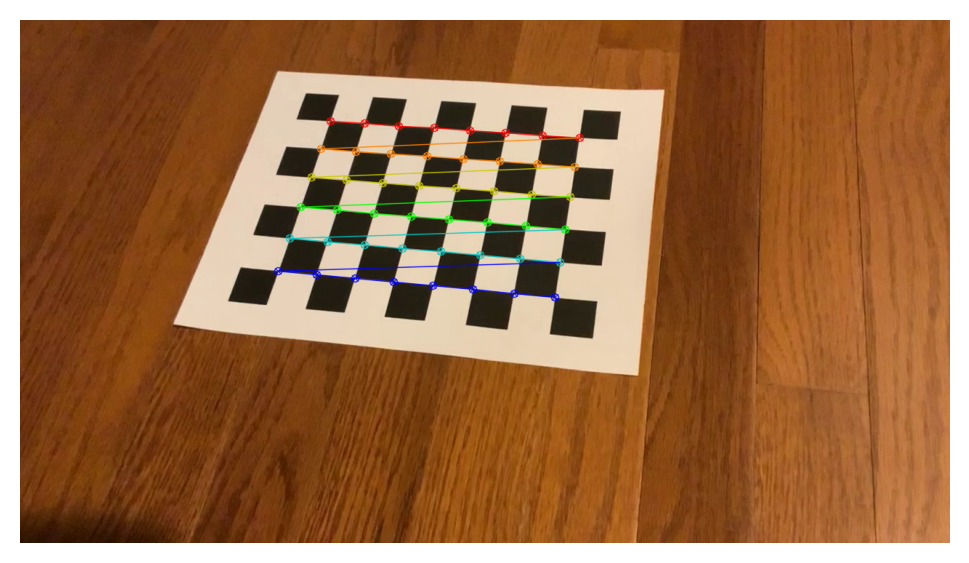

In [4]:
CHECKER = (8,6)
flag_found, corners = cv2.findChessboardCorners(img_gray, CHECKER)

print(flag_found)
print(corners.shape)
print(corners)

img_corner = img.copy()
cv2.drawChessboardCorners(img_corner, CHECKER, corners, flag_found)
cv2_imshow(img_corner) 

The detected pixel location of corners are refined by [cv2.cornerSubPix](https://docs.opencv.org/master/dd/d1a/group__imgproc__feature.html#ga354e0d7c86d0d9da75de9b9701a9a87e)

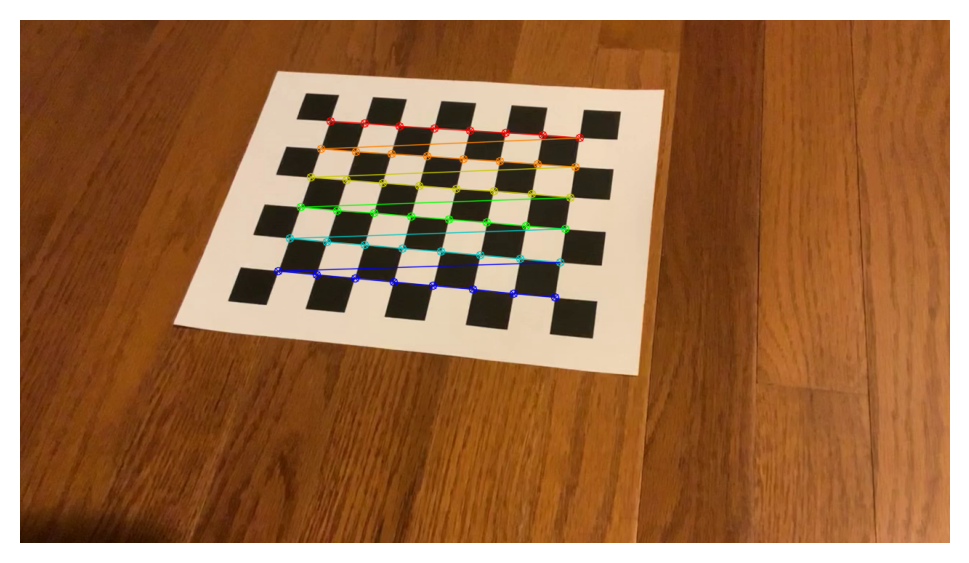

In [5]:
criteria_subpix = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
corners_refined = cv2.cornerSubPix(img_gray, corners, (11,11), (-1,-1), criteria_subpix)

#print(corners_refined)
# print(corners_refined.shape)
#print(corners_refined.dtype)


img_corner = img.copy()

cv2.drawChessboardCorners(img_corner, CHECKER, corners, flag_found)
cv2_imshow(img_corner) 

What are those colored dots and lines? They represent the order that the detected corners are saved in the variarble `corners`.

To calibrate the camera, we have to provide the coordinates of those corners in the world frame, according to the order illustrated by the color.

But defining those coordinates are not difficult, as all of the corners lie in a 2D plane. Let the origin of the world frame be at the first corner. The $x$-axis is pointing toward the second corner, and the $y$-axis is pointing down toward the first oranage corner. According to the right-hand rule, the $z$ axis will be pointing into the floor.

Then, the first corner is `[[0,0,0]]` (Note: it is `1x3 np.array`), and the second corner is `[[1,0,0]]` times the actual size of the square, which is `25 mm = 0.025 m`

Now, we have to define a container that stores the actual 3D coordinates of corners represented by `1x3 np.array`, according to the same order as those are detected. For example, `checker_width*[ [[0,0,0]], [[1,0,0]], [[2,0,0]], ..., [[7,0,0]], [[0,1,0]], ... , [[7,5,0]] ]`. 
Also, the data type ** must be `np.float32`**

In [6]:
# Creating vector to store vectors of 3D points for each checkerboard image
CHECKER_WIDTH = 0.025

obj_points = np.zeros( (CHECKER[0] * CHECKER[1], 1, 3 ), np.float32)
for i in range(CHECKER[1]):
    for j in range(CHECKER[0]):
         obj_points[i*CHECKER[0]+j,0,:]=np.array([[j,i,0]])
obj_points *= CHECKER_WIDTH
            
            
print(obj_points.shape)
print(obj_points.dtype)
print(obj_points)


(48, 1, 3)
float32
[[[0.    0.    0.   ]]

 [[0.025 0.    0.   ]]

 [[0.05  0.    0.   ]]

 [[0.075 0.    0.   ]]

 [[0.1   0.    0.   ]]

 [[0.125 0.    0.   ]]

 [[0.15  0.    0.   ]]

 [[0.175 0.    0.   ]]

 [[0.    0.025 0.   ]]

 [[0.025 0.025 0.   ]]

 [[0.05  0.025 0.   ]]

 [[0.075 0.025 0.   ]]

 [[0.1   0.025 0.   ]]

 [[0.125 0.025 0.   ]]

 [[0.15  0.025 0.   ]]

 [[0.175 0.025 0.   ]]

 [[0.    0.05  0.   ]]

 [[0.025 0.05  0.   ]]

 [[0.05  0.05  0.   ]]

 [[0.075 0.05  0.   ]]

 [[0.1   0.05  0.   ]]

 [[0.125 0.05  0.   ]]

 [[0.15  0.05  0.   ]]

 [[0.175 0.05  0.   ]]

 [[0.    0.075 0.   ]]

 [[0.025 0.075 0.   ]]

 [[0.05  0.075 0.   ]]

 [[0.075 0.075 0.   ]]

 [[0.1   0.075 0.   ]]

 [[0.125 0.075 0.   ]]

 [[0.15  0.075 0.   ]]

 [[0.175 0.075 0.   ]]

 [[0.    0.1   0.   ]]

 [[0.025 0.1   0.   ]]

 [[0.05  0.1   0.   ]]

 [[0.075 0.1   0.   ]]

 [[0.1   0.1   0.   ]]

 [[0.125 0.1   0.   ]]

 [[0.15  0.1   0.   ]]

 [[0.175 0.1   0.   ]]

 [[0.    0.125 0.   ]

Then, both of intrinsic and extrinsic parameters are obtained by [cv2.calibrateCamera](https://docs.opencv.org/master/d9/d0c/group__calib3d.html#ga3207604e4b1a1758aa66acb6ed5aa65d). Note the `obj_points` and `corners_refined` **must be nested in `[]`.** The command `img_gray.shape[::-1]` swap row/column.

This yields the calibration matrix $K$, and the distortion coefficients in the order of $k_1,k_2, p_1,p_2,k_3$. 
Further, the rotation matrix is given by `rvecs` in terms of the [Rodriguez paramter](https://mathworld.wolfram.com/RodriguesRotationFormula.html), and the translation vector is given by `tvecs`

Note: the distortion coefficients are normalized in some way, so they cannot be directly utilized in the formula in the note.

In [7]:
err, K, dist_coeff, rvecs, tvecs = cv2.calibrateCamera([obj_points], [corners_refined], img_gray.shape[::-1], None, None)

print(err)
print(K)
print(dist_coeff)

R, _ = cv2.Rodrigues(rvecs[0])
T = tvecs[0]


print(R)
print(-R.T@T) # vector from W to C resolved in W, i.e., where was the camera in W?


0.14428778390418448
[[1.29524985e+03 0.00000000e+00 6.03553292e+02]
 [0.00000000e+00 1.28919264e+03 3.14766116e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
[[ 3.40484574e-01 -1.60600496e+01  7.21520309e-03 -1.12985405e-02
   2.85445707e+02]]
[[ 0.97446799 -0.18619282  0.12547655]
 [ 0.08700701  0.82833153  0.55344074]
 [-0.20698288 -0.52839295  0.82338265]]
[[ 0.2325639 ]
 [ 0.4078212 ]
 [-0.48538075]]


Now we have both of the intrinsic paramter $K$ and the extrinsic paramter $(R,T)$, from which we can compute the projection matrix $M$. 

Using this any point in the 3D world frame can be projected to the image plane. Here we draw a line starting from the origin and pointing toward the $x$-axis, whose length is equal to the checker width.

[[0.    0.025]
 [0.    0.   ]
 [0.    0.   ]
 [1.    1.   ]]
[[284.02631062 312.45766886]
 [ 93.5033591   94.67879914]
 [  0.66328068   0.65810611]]
[[428.21435764 474.78311578]
 [140.97102754 143.86555279]]
[[428 474]
 [140 143]]
[[ 0.     0.   ]
 [ 0.     0.   ]
 [ 0.    -0.025]
 [ 1.     1.   ]]
[[284.02631062 267.53934081]
 [ 93.5033591   69.18674204]
 [  0.66328068   0.64269611]]
[[428.21435764 416.27658043]
 [140.97102754 107.65078623]]
[[428 416]
 [140 107]]


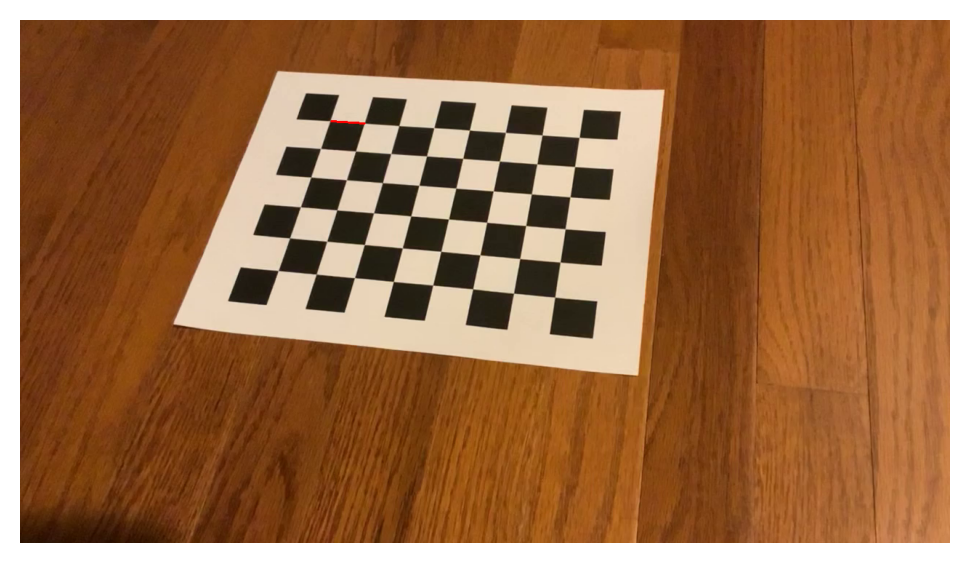

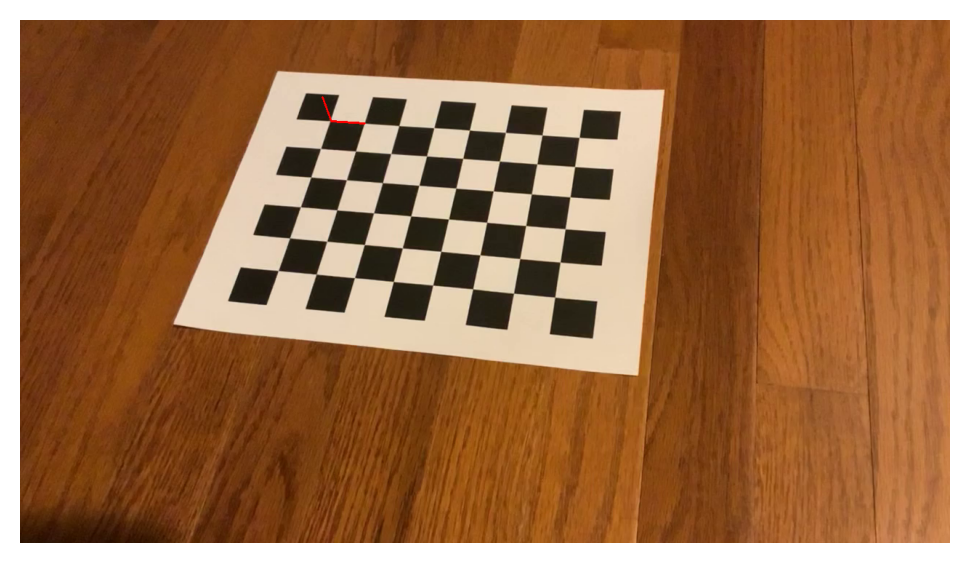

In [9]:
M = K @ np.concatenate( (R, T) , axis=1)


p_W = np.array([ [0,0,0,1], [CHECKER_WIDTH, 0, 0, 1] ]).T 
print(p_W)
p_I = M @ p_W
print(p_I)
p_I = p_I[0:2,:]/p_I[2,:]
print(p_I)
p_I = p_I.astype(int)
print(p_I)

img_line = img.copy()

cv2.line(img_line, (p_I[0,0], p_I[1,0]), (p_I[0,1], p_I[1,1]), (0,0,255), 2)
cv2_imshow(img_line)

p_W = np.array([ [0,0,0,1], [0, 0, -CHECKER_WIDTH, 1] ]).T 
print(p_W)
p_I = M @ p_W
print(p_I)
p_I = p_I[0:2,:]/p_I[2,:]
print(p_I)
p_I = p_I.astype(int)
print(p_I)
cv2.line(img_line, (p_I[0,0], p_I[1,0]), (p_I[0,1], p_I[1,1]), (0,0,255), 2)
cv2_imshow(img_line)

p_W = np.array([ [0,0,0,1], [0, CHECKER_WIDTH, 0, 1] ]).T 
print(p_W)
p_I = M @ p_W
print(p_I)
p_I = p_I[0:2,:]/p_I[2,:]
print(p_I)
p_I = p_I.astype(int)
print(p_I)
cv2.line(img_line, (p_I[0,0], p_I[1,0]), (p_I[0,1], p_I[1,1]), (0,0,255), 2)
cv2_imshow(img_line)
